# Анализ данных с помощью функционала Rete

Анализ симуляционных данных на основе сайта bluesleep.ru

В данных присутствуют пользователи, пришедшие с двух разных рекламных каналов РК

Предлагается исследовать зависимость конверсии от вида РК, а также детально изучить

"проблемы" пользователей из каждого канала

## Импорт данных

In [5]:
from retentioneering import init_config
import pandas as pd
import numpy as np
from eli5.sklearn import PermutationImportance  
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('bluesleep_sim_data_v1_1.csv')


In [7]:
user_id = 'user_id'
event_name = 'event_name'
event_time = 'event_timestamp'
source = 'utm_source'

filename = 'bluesleep_sim_data.csv'
target_events = ['https://bluesleep.ru/order/submit'] # таргет событие

In [8]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col=user_id, # column by which we split users / sessions / whatever
    event_col=event_name, # column that describes event
    event_time_col=event_time, # column that describes timestamp of event
    positive_target_event='passed', # name of positive target event
    negative_target_event='lost', # name of negative target event
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        'event_list':target_events
    },
    neg_target_definition={}
)

data = data.retention.prepare()

In [9]:
print('pos events:', len(data[data[event_name] == 'passed']))

pos events: 408


## Предобработка

In [10]:
# убираем из названия событий общий префикс https://bluesleep.ru/
data[event_name] = data[event_name].apply(lambda x: x.split('https://bluesleep.ru/')[1] if x.find('https://bluesleep.ru/') != -1 else x )

In [11]:
# выносим признак utm_source в отдельное поле

In [12]:
data[source] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else '')
data[event_name] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else x)

In [13]:
# выделим списки пользователей пришедших по разным каналам
users_facebook = set(data[data[source] == 'facebook'][user_id])
users_blog = set(data[data[source] == 'blog'][user_id])

In [14]:
data[source]= data.apply(lambda x: 'facebook' if (x[user_id] in users_facebook) else 'blog', axis = 1)

In [15]:
# обратим внимание на соотношение пользователей по РК
data[source].value_counts()

facebook    12816
blog         6372
Name: utm_source, dtype: int64

## Анализ общего набора данных

### Граф

Посмотрим расположение событий в виде графа

Проверяем, что все события присутствуют, корректно отображаются. 

Однако, сделать вывод о проблемном месте по данной картине затруднительно

In [16]:
data.retention.plot_graph(thresh=0.05, width=800, height=800)

'experiments/index_2019-11-14 12_45_53_668589.html'

### Кластеризация

Сделаем кластеризацию и оценим, на какие кластеры распадаются наши данные по конверсии

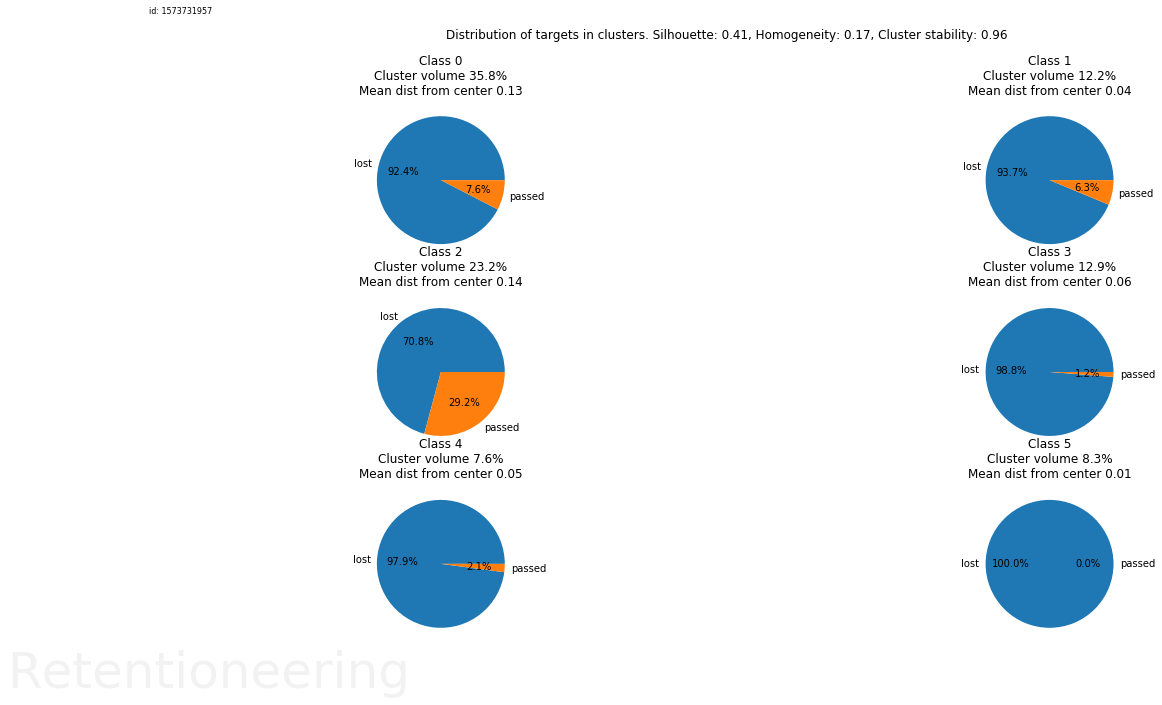

In [17]:
_ = data.retention.get_clusters(plot_type='cluster_pie', n_clusters=6, refit_cluster=True, method='simple_cluster')

array([2, 4, 4, ..., 1, 0, 1], dtype=int32)

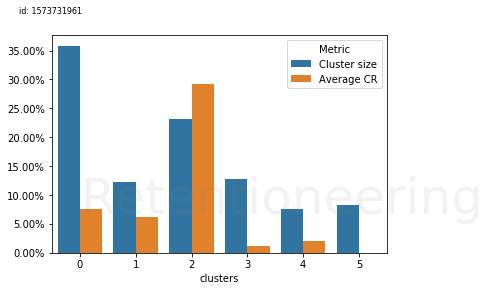

In [18]:
data.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

array([2, 4, 4, ..., 1, 0, 1], dtype=int32)

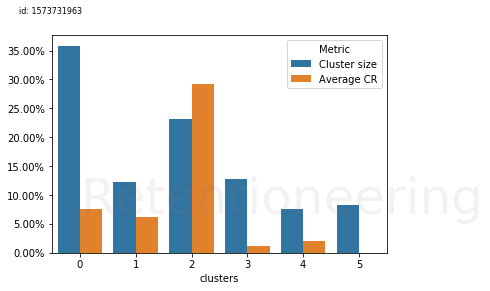

In [19]:
data.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

In [20]:
# data.retention.learn_tsne(plot_type='targets', refit=True, targets=[source])

,0,1
4035252015317224,-0.411023,1.398111
8787916473450807,63.648884,65.832832
10343063710959386,-10.475072,80.779076
10367023919443739,-57.873550,51.363503
14644993406732336,-58.668751,-8.507800
...,...,...
9211184395632652112,-59.576771,-12.580901
9219484628138534504,-58.668751,-8.507800
9222385022196670624,25.835516,-37.199944
9222501761129383702,-19.117317,-12.394140


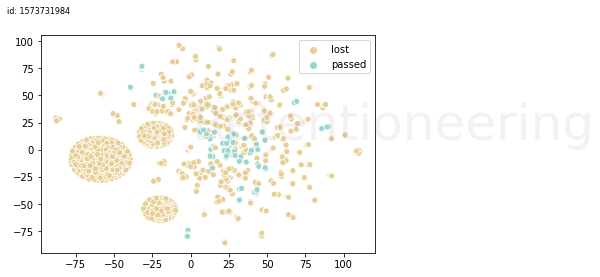

In [21]:
data.retention.learn_tsne(perplexity=4, plot_type='targets', refit=True)

array([2, 4, 4, ..., 1, 0, 1], dtype=int32)

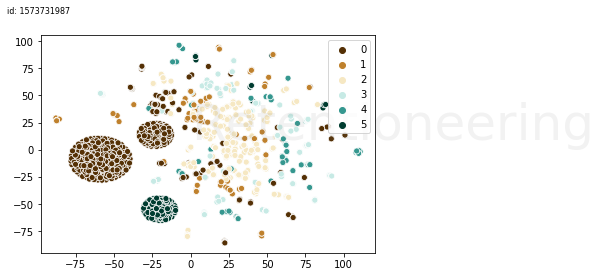

In [22]:
data.retention.get_clusters(n_clusters=6, plot_type='cluster_tsne', refit_cluster=True)

### Изучим влияние событий на разные кластеы

#### Проблемные кластеры

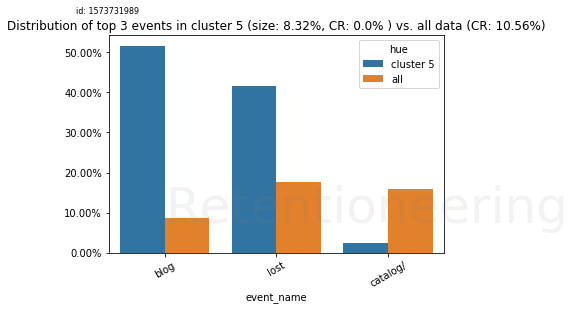

In [23]:
data.retention.cluster_event_dist(5, n=3)

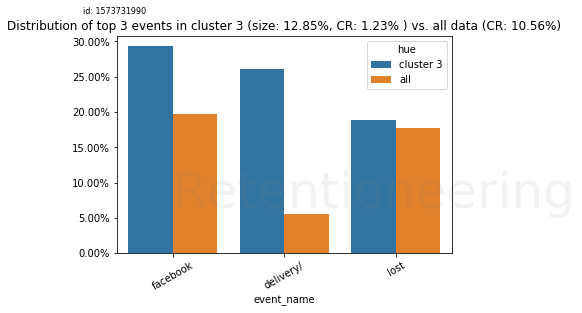

In [24]:
data.retention.cluster_event_dist(3, n=3)

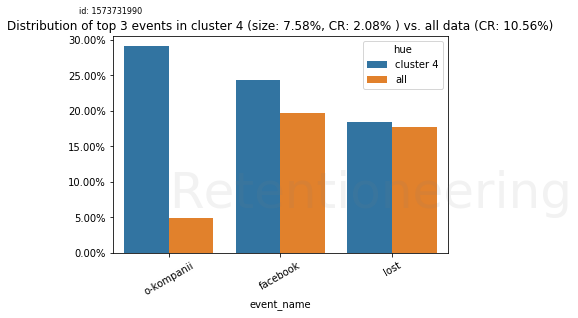

In [25]:
data.retention.cluster_event_dist(4, n=3)

#### Кластеры с хорошей конверсией

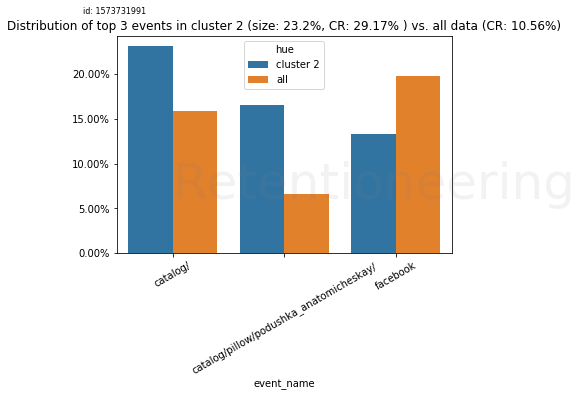

In [26]:
data.retention.cluster_event_dist(2, n=3)

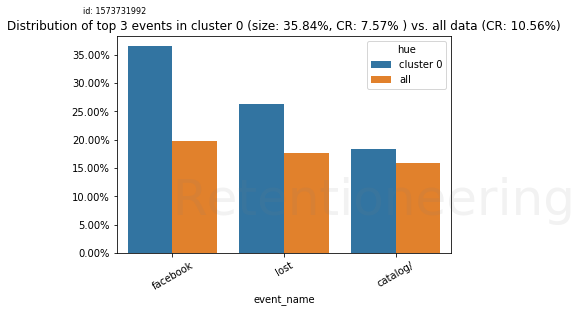

In [27]:
data.retention.cluster_event_dist(0, n=3)

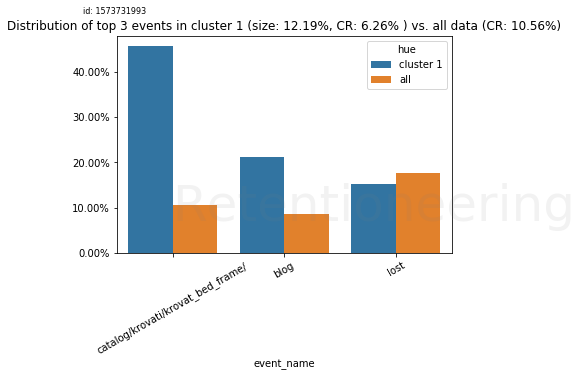

In [28]:
data.retention.cluster_event_dist(1, n=3)

### Выводы: 
вид РК существенно влияет на распределение в кластерах. Необходим более глубокий анализ по каждому РК

## Анализ данных по РК Facebook

In [29]:
data_fb = data[data[source] == 'facebook'].copy()

In [30]:
data_fb.retention.plot_graph(thresh=0.05, width=800, height=800)

'experiments/index_2019-11-14 12_46_33_947016.html'

### Кластеризация

array([3, 4, 2, ..., 1, 1, 5], dtype=int32)

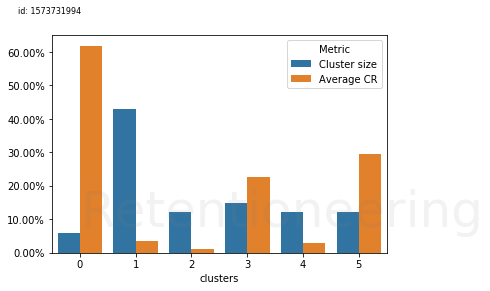

In [31]:
data_fb.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

array([3, 4, 2, ..., 1, 1, 5], dtype=int32)

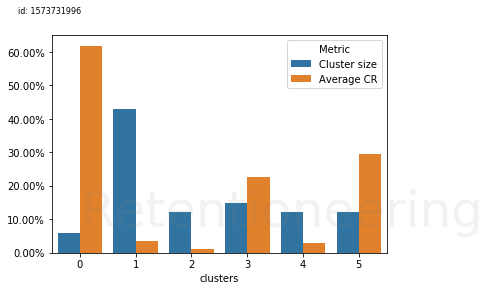

In [32]:
data_fb.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

,n,n - 1,n - 2,n - 3
passed,1.0,0.0,0.000000,0.000000
order/confirmation,0.0,1.0,0.000000,0.000000
order/payment-option-switcher,0.0,0.0,0.330409,0.052632
catalog/,0.0,0.0,0.000000,0.649123
catalog/krovati/krovat_bed_frame/,0.0,0.0,0.219298,0.020468
order/,0.0,0.0,0.000000,0.277778
catalog/matrasy/bluesleep_gravity/,0.0,0.0,0.140351,0.000000
catalog/pillow/podushka_anatomicheskay/,0.0,0.0,0.309942,0.000000


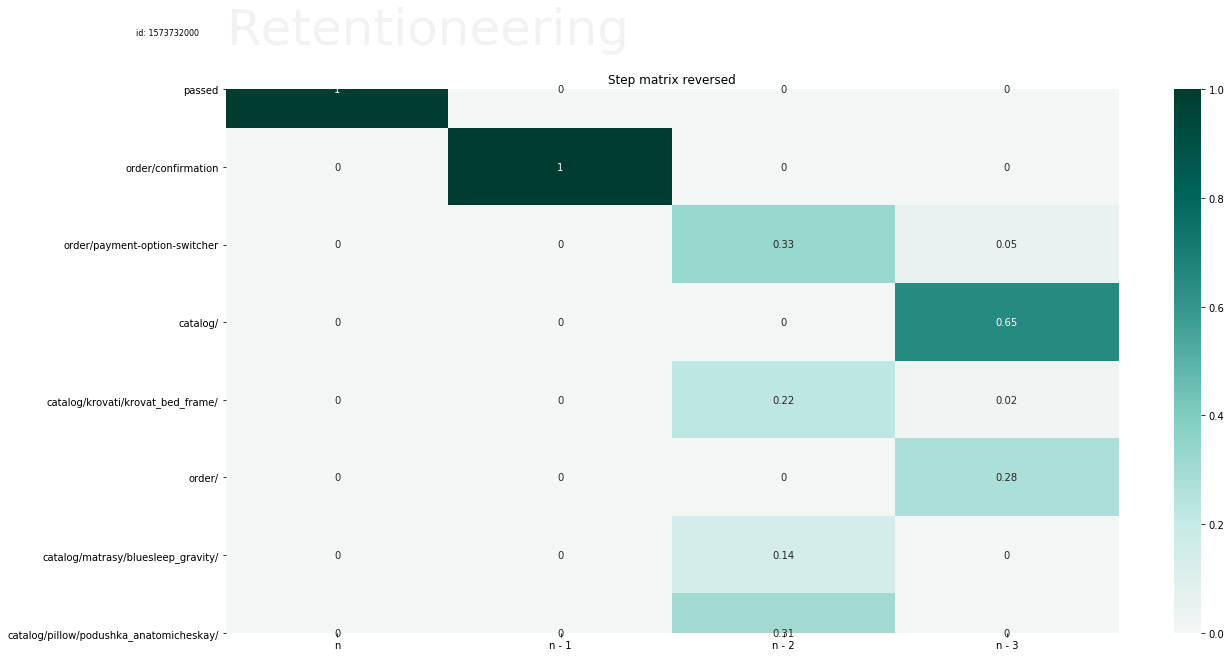

In [33]:
data_fb.retention.get_step_matrix(max_steps=4, reverse = 'pos')

,n,n - 1,n - 2,n - 3
lost,1.0,0.000000,0.000000,0.000000
facebook,0.0,0.361087,0.283434,0.256255
catalog/,0.0,0.223900,0.234685,0.103106
o-kompanii,0.0,0.065142,0.053063,0.048318
order/payment-option-switcher,0.0,0.011648,0.010785,0.004745
catalog/krovati/krovat_bed_frame/,0.0,0.050475,0.034513,0.026747
delivery/,0.0,0.117343,0.053926,0.040121
order/,0.0,0.016393,0.018119,0.013374
catalog/pillow/podushka_anatomicheskay/,0.0,0.103538,0.030198,0.031493
order/confirmation,0.0,0.024590,0.006040,0.001726


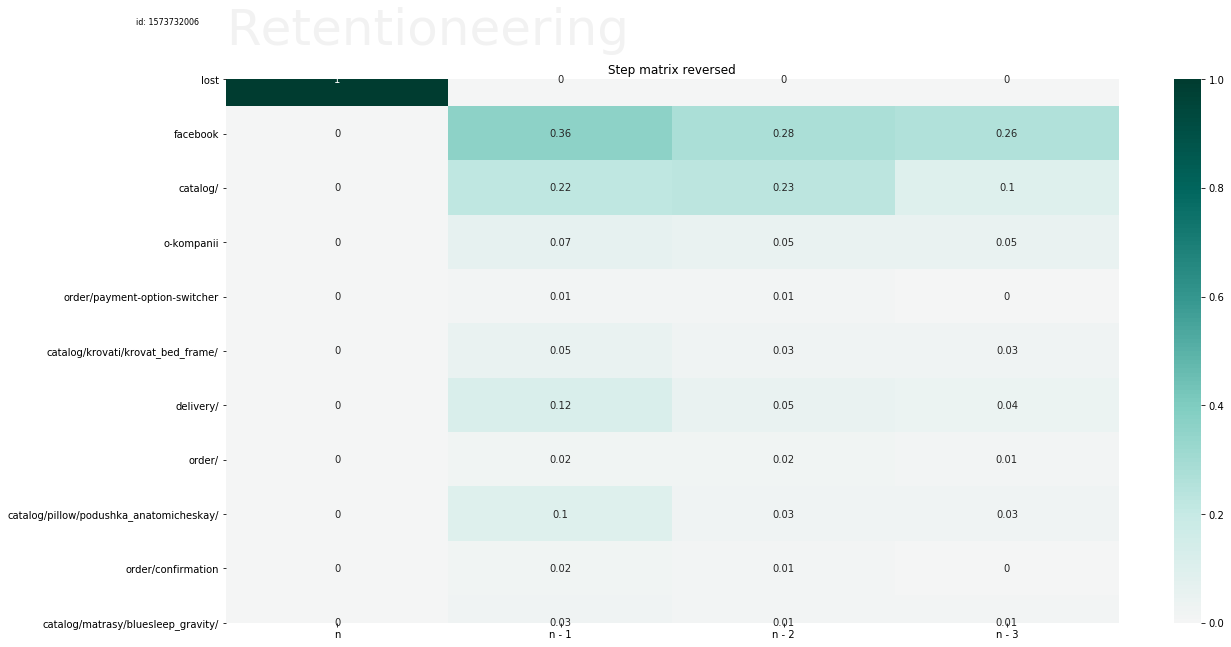

In [34]:
data_fb.retention.get_step_matrix(max_steps=4, reverse = 'neg')

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
Accumulated lost,0.0,0.000000,-0.262295,-0.464193,-0.647110,-0.750647,-0.832614,-0.883520,-0.928818,-0.954271,...,-0.989646,-0.993097,-0.995255,-0.996549,-0.997412,-0.998706,-0.998706,-0.998706,-0.998706,-0.998706
catalog/,0.0,0.339933,0.035592,0.072011,0.042355,0.049292,0.028278,0.016011,0.039098,0.011836,...,0.004676,0.008524,-0.000431,0.001691,0.005539,0.002554,0.002985,0.000000,0.000000,0.000000
catalog/pillow/podushka_anatomicheskay/,0.0,0.000000,0.198714,0.011370,0.056800,0.020722,0.029677,0.016115,0.008920,0.011906,...,0.005970,-0.000431,0.002985,0.000000,0.002554,0.002554,0.002985,0.002985,0.000000,0.000000
order/confirmation,0.0,0.000000,0.000000,0.335017,0.057544,0.248554,0.092468,0.085238,0.042619,0.046467,...,0.008092,0.002985,0.005539,0.002985,0.005970,0.002985,0.000000,0.000000,0.002985,0.000000
passed,0.0,0.000000,0.000000,0.000000,0.343284,0.059701,0.250746,0.095522,0.089552,0.044776,...,0.008955,0.005970,0.002985,0.002985,0.002985,0.005970,0.002985,0.000000,0.000000,0.002985
Accumulated passed,0.0,0.000000,0.000000,0.000000,0.000000,0.343284,0.402985,0.653731,0.749254,0.838806,...,0.985075,0.994030,1.000000,1.002985,1.005970,1.008955,1.014925,1.017910,1.017910,1.017910
order/payment-option-switcher,0.0,0.000000,0.000000,0.000000,0.167888,0.044672,0.051108,0.024709,0.030679,0.008524,...,0.002985,0.002985,0.002985,0.005970,0.000000,0.000000,0.000000,0.002985,0.000000,0.000000
facebook,0.0,-0.003304,-0.010861,0.016645,0.011815,0.021912,0.007849,0.037338,0.010542,0.005866,...,0.011077,0.004676,-0.001294,0.008092,0.002985,0.002985,0.000000,0.000000,0.000000,0.000000
order/,0.0,0.000000,0.000000,0.183433,0.029746,0.037407,0.006729,0.029781,0.009783,0.010646,...,-0.000863,0.002554,0.005970,0.000000,0.000000,0.000000,0.002985,0.000000,0.000000,0.000000
catalog/krovati/krovat_bed_frame/,0.0,0.000000,0.176976,0.039857,0.025293,0.028417,0.027193,0.005504,0.008920,0.022155,...,0.002985,0.008524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


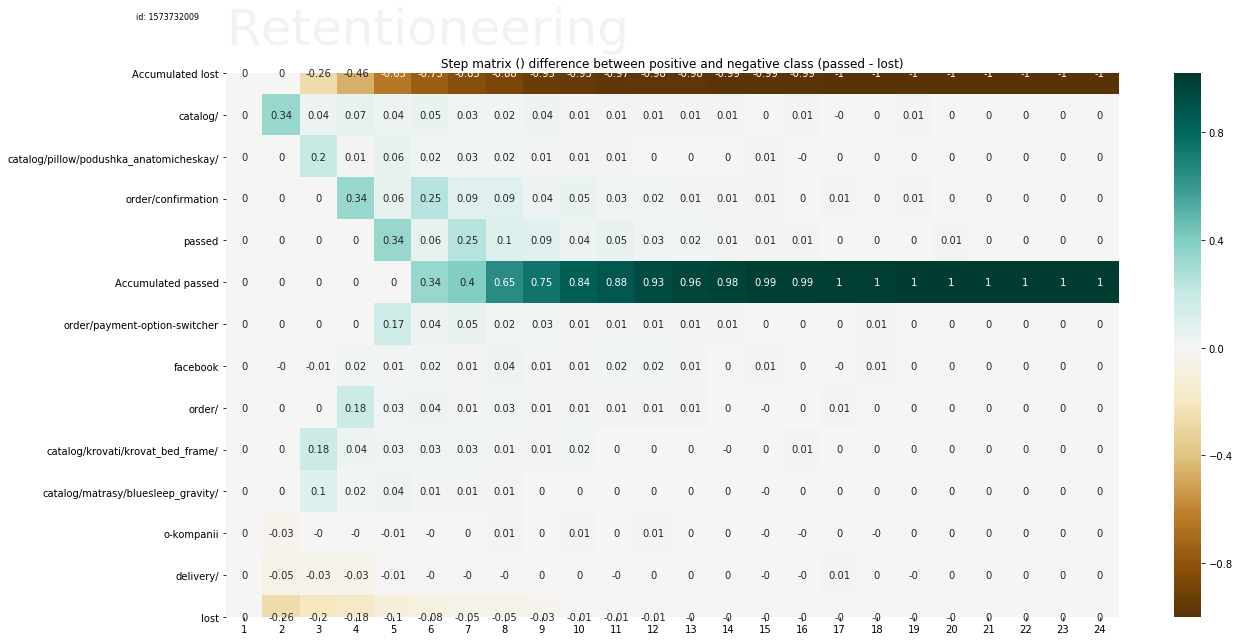

In [35]:
diff_filter = data_fb.retention.create_filter()

# calculate difference table between two groups
data_fb.retention.get_step_matrix_difference(diff_filter, max_steps=30)

### Классификация

In [36]:
preprocess_data = data_fb[~data_fb[event_name].isin(['order/confirmation', 'order/payment-option-switcher', 'order/'])]
model    = preprocess_data.retention.create_model(ngram_range=(1,2))
features = preprocess_data.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(data_fb.retention.get_positive_users())

In [37]:
model.permutation_importance(features, target, thresh=0.)


                ROC-AUC: 0.8759410454200095
                PR-AUC: 0.388997463610391
                Accuracy: 0.8748586505842443
                


### Выводы:
Для РК facebook наблюдается сильный отток пользователей со страницы delivery

## Анализ данных по РК blog

In [38]:
data_blog = data[data[source] == 'blog'].copy()

In [39]:
data_blog.retention.plot_graph(thresh=0.05, width=800, height=800)

'experiments/index_2019-11-14 12_46_57_891643.html'

### Кластеризация

array([4, 1, 2, ..., 2, 1, 1], dtype=int32)

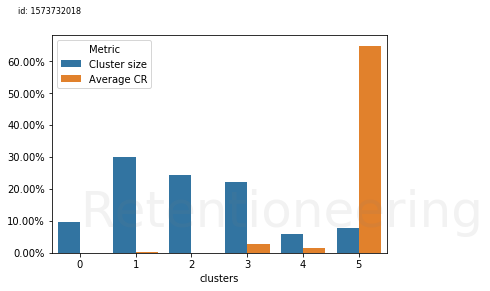

In [40]:
data_blog.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

array([4, 1, 2, ..., 2, 1, 1], dtype=int32)

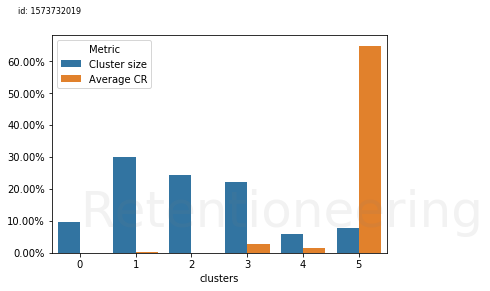

In [41]:
data_blog.retention.get_clusters(method='simple_cluster', n_clusters=6, plot_type='cluster_bar', use_csi=False, refit_cluster=True)

,n,n - 1,n - 2,n - 3
passed,1.0,0.0,0.0,0.000000
order/confirmation,0.0,1.0,0.0,0.000000
order/payment-option-switcher,0.0,0.0,1.0,0.151515
order/,0.0,0.0,0.0,0.848485


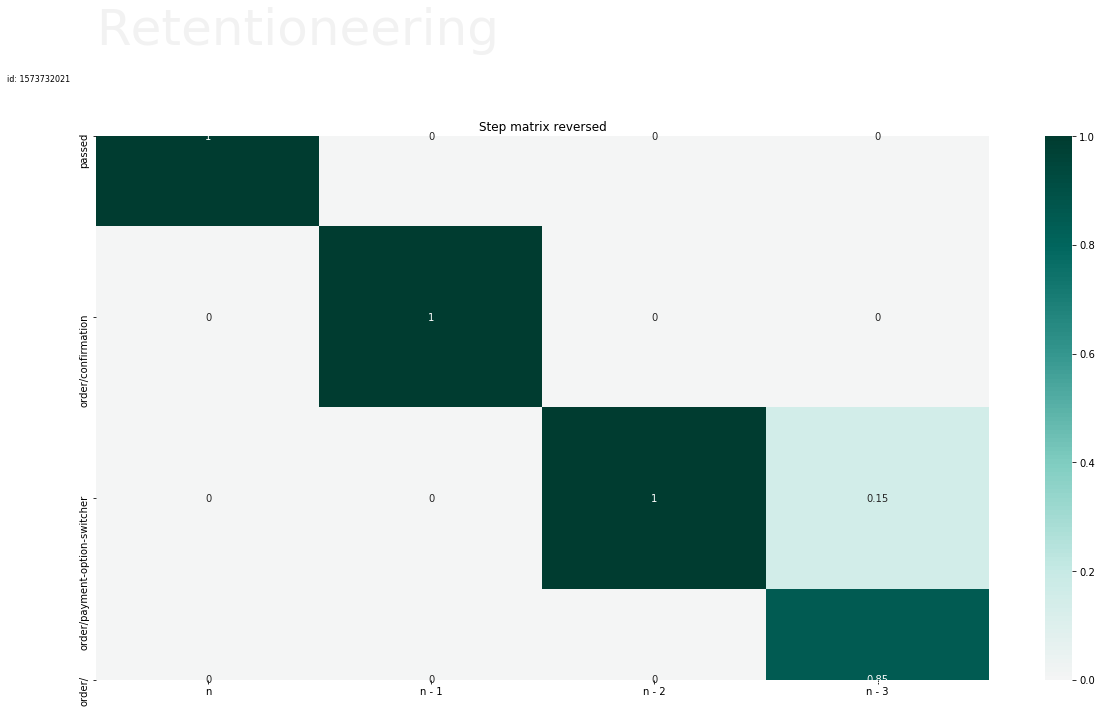

In [42]:
data_blog.retention.get_step_matrix(max_steps=4, reverse = 'pos')

,n,n - 1,n - 2,n - 3
lost,1.0,0.000000,0.000000,0.000000
catalog/krovati/krovat_bed_frame/,0.0,0.330241,0.217996,0.176252
blog,0.0,0.322820,0.273655,0.178108
catalog/pillow/podushka_anatomicheskay/,0.0,0.121521,0.074212,0.074212
catalog/,0.0,0.065863,0.109462,0.073284
o-kompanii,0.0,0.043599,0.039889,0.029685
order/payment-option-switcher,0.0,0.016698,0.013915,0.001855
delivery/,0.0,0.069573,0.025974,0.028757
order/,0.0,0.020408,0.023191,0.021336
order/confirmation,0.0,0.009276,0.000928,0.001855


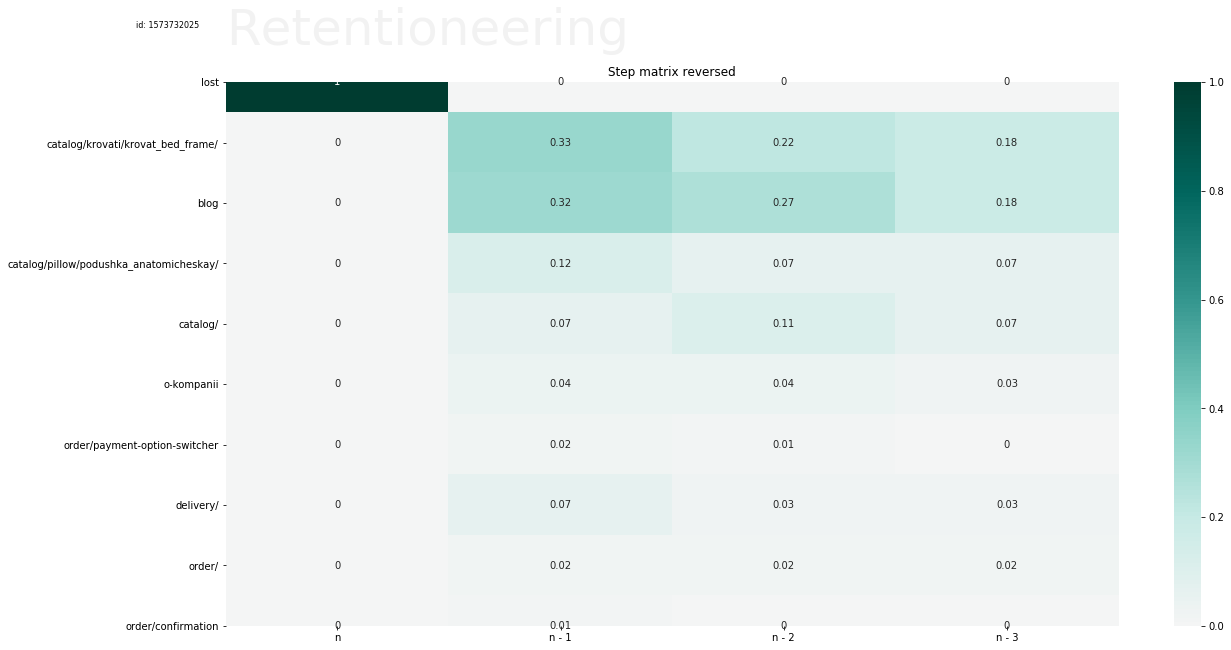

In [43]:
data_blog.retention.get_step_matrix(max_steps=4, reverse = 'neg')

### Классификация

In [44]:
preprocess_data = data_blog[~data_blog[event_name].isin(['order/confirmation', 'order/payment-option-switcher', 'order/'])]
model    = preprocess_data.retention.create_model(ngram_range=(1,2))
features = preprocess_data.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(data_blog.retention.get_positive_users())

In [45]:
model.permutation_importance(features, target, thresh=0.)


                ROC-AUC: 0.7343073593073594
                PR-AUC: 0.1070761448116613
                Accuracy: 0.9423076923076923
                


### Выводы:
Для РК blog сильно гасит конверсию страницы: catalog/krovati/krovat_bed_frame/ и delivery/

In [46]:
data

,user_id,event_name,event_timestamp,utm_source,next_event,next_timestamp
2610,4035252015317224,facebook,2019-09-16 16:55:38.165011968,facebook,catalog/,2019-09-17 01:02:45.820008192
2695,4035252015317224,catalog/,2019-09-17 01:02:45.820008192,facebook,catalog/pillow/podushka_anatomicheskay/,2019-09-19 20:20:10.380321792
3462,4035252015317224,catalog/pillow/podushka_anatomicheskay/,2019-09-19 20:20:10.380321792,facebook,lost,2019-09-19 20:20:11.380321792
16489,4035252015317224,lost,2019-09-19 20:20:11.380321792,facebook,NaN,NaT
6745,8787916473450807,blog,2019-10-01 15:35:17.019945728,blog,o-kompanii,2019-10-03 05:29:39.794527232
...,...,...,...,...,...,...
3184,9222501761129383702,catalog/krovati/krovat_bed_frame/,2019-09-18 21:35:51.517752576,facebook,lost,2019-09-18 21:35:52.517752576
16431,9222501761129383702,lost,2019-09-18 21:35:52.517752576,facebook,NaN,NaT
2367,9223320337369398956,blog,2019-09-15 18:08:02.909346816,blog,catalog/krovati/krovat_bed_frame/,2019-09-17 07:09:14.151507712
2772,9223320337369398956,catalog/krovati/krovat_bed_frame/,2019-09-17 07:09:14.151507712,blog,lost,2019-09-17 07:09:15.151507712


In [47]:
!mkdir img

mkdir: cannot create directory ‘img’: File exists


### * Визуализация рекламных каналов

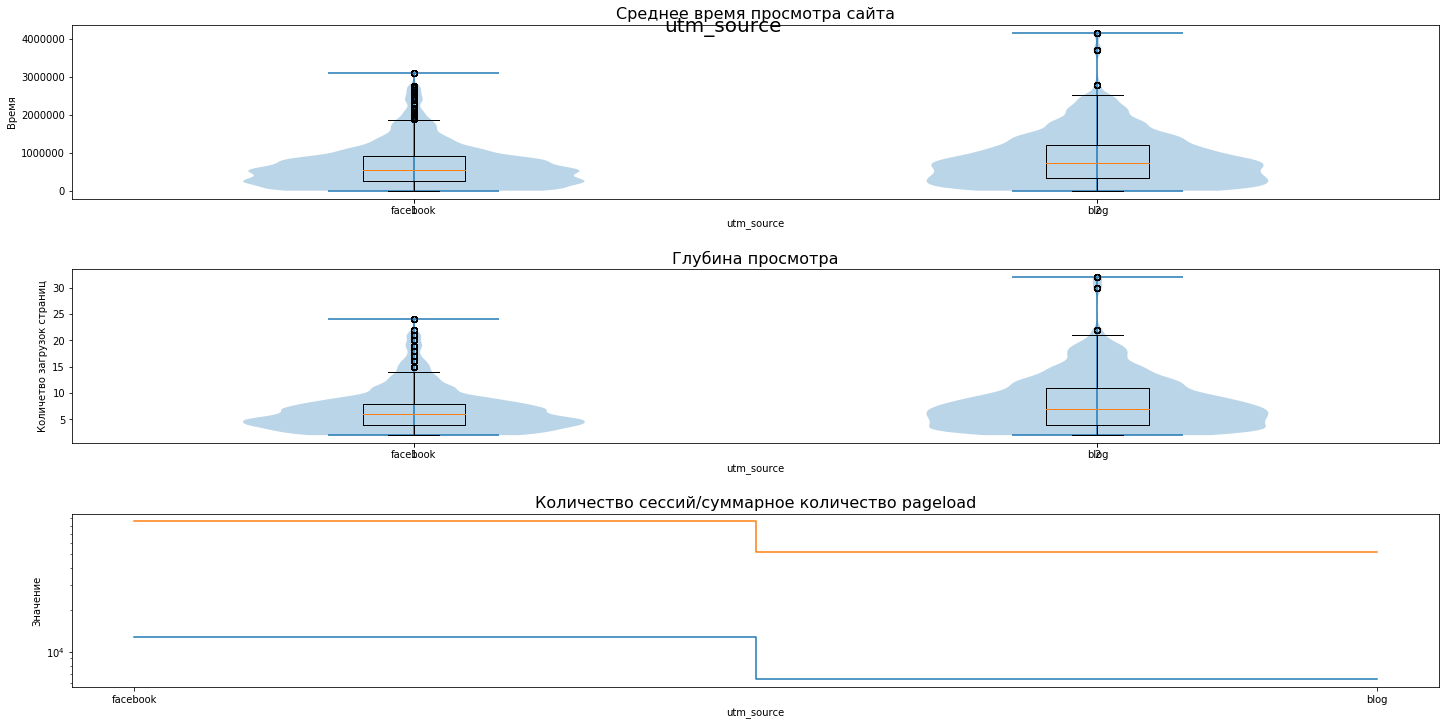

In [51]:
def foo(lst):
    def _format(x):
        res = ''
        for c, k in enumerate(x):
            if c%10==9:
                res+='\n'
            res+=k
        return res
    lst_temp = [[_format(i),[kk for kk in k if abs(kk)>1e-3]] for i,k in lst if i not in ['cpc', ''] ][:15]
    return lst_temp
KEY = 'utm_source'
dct_of_users = data.groupby('utm_source').apply(lambda x : x.user_id.to_numpy()).to_dict()
user_session_aggergation_time             = data.groupby(user_id).apply(lambda x: (x[event_time].max()-x[event_time].min()).total_seconds()).to_dict()
user_session_aggergation_num_of_pageloads = data.groupby(user_id).apply(lambda x:len(x)).to_dict()
dct_results_time = {key:np.array([user_session_aggergation_time[i] for i in lst]) for key, lst in dct_of_users.items()}
lst_time = [[k, v] for k,v in sorted(dct_results_time.items(), key = lambda x:-len(x[1]))]

dct_results_num_of_pageloads = {key:np.array([user_session_aggergation_num_of_pageloads[i] for i in lst]) for key, lst in dct_of_users.items()}
lst_num_of_pageloads = [[k, v] for k,v in sorted(dct_results_num_of_pageloads.items(), key = lambda x:-len(x[1]))]

lst_time             = foo(lst_time)
lst_num_of_pageloads = foo(lst_num_of_pageloads)

fig, ax = plt.subplots(3, 1)
fig.set_size_inches((20, 10))
fig.suptitle(KEY, fontsize = 20)
# plt.setp(axes, xticklabels=[i[0] for i in lst])

lst = lst_time

plt.setp(ax, xticks=range(1, 1+len(lst)), xticklabels=[i[0] for i in lst])

ax[0].set_title('Среднее время просмотра сайта', fontsize = 16)
ax[0].set_ylabel('Время')
ax[0].set_xlabel(KEY)
ax[0].violinplot([i[1] for i in lst])
ax[0].boxplot([i[1] for i in lst])

ax[0].set_xlim(1/2, len(lst)+1/2)
#     ax[0].set_yscale('log')


ax[2].set_title('Количество сессий/суммарное количество pageload', fontsize = 16)
ax[2].set_ylabel('Значение')
ax[2].set_xlabel(KEY)
ax[2].step(np.array(range(1, 1+len(lst))), [len(i[1]) for i in lst], 
           where='mid', label = 'Количетво сессий', )
ax[2].step(np.array(range(1, 1+len(lst))), [sum(i[1]) for i in lst_num_of_pageloads[:15]], 
           where='mid', label = 'Количетво загрузок страниц')
# ax[2].set_xlim(1/2, len(lst)+1/2)
ax[2].set_yscale('log')


lst = lst_num_of_pageloads
ax[1].set_title('Глубина просмотра', fontsize = 16)
ax[1].set_ylabel('Количетво загрузок страниц')
ax[1].set_xlabel(KEY)
ax[1].violinplot([i[1] for i in lst])
ax[1].boxplot([i[1] for i in lst])
ax[1].set_xlim(1/2, len(lst)+1/2)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.savefig(f'img/1_month_simulation_data.png')
plt.show()
